In [93]:
# Core
import time
import pandas as pd
import numpy as np 
import pygame
from functools import reduce
from tqdm import tqdm

import matplotlib.pyplot as plt

# NLP
import re
import gensim
import nltk
import spacy
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from pymystem3 import Mystem
from string import punctuation
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk import tokenize
from sentence_transformers import SentenceTransformer

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [94]:
# gpu for mac m1
mps_device = torch.device("mps")

In [95]:
train = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/train.csv")
test = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [96]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [97]:
target_columns = ["toxic", "severe_toxic",
                  "obscene", "threat",
                  "insult", "identity_hate"]

In [98]:
test = test.merge(test_labels, on="id")

In [99]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [100]:
closed_test = test[(test[target_columns] == -1).any(axis=1)].reset_index(drop=True)
test = test[~(test[target_columns] == -1).any(axis=1)].reset_index(drop=True)

In [101]:
for data in [train, test]:
    print(train.isnull().sum(), '\n')

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 



In [102]:
print("Train")
for col in target_columns:
    print(train[col].value_counts(normalize=True))

Train
0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


In [103]:
print("Test")
for col in target_columns:
    print(test[col].value_counts(normalize=True))

Test
0    0.904811
1    0.095189
Name: toxic, dtype: float64
0    0.994264
1    0.005736
Name: severe_toxic, dtype: float64
0    0.942308
1    0.057692
Name: obscene, dtype: float64
0    0.996702
1    0.003298
Name: threat, dtype: float64
0    0.946435
1    0.053565
Name: insult, dtype: float64
0    0.988871
1    0.011129
Name: identity_hate, dtype: float64


In [104]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
mystem = Mystem()

def preprocess(text, stemming=True):
    if stemming:
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in stop_words\
                  and token != " "\
                  and token.strip() not in punctuation]
    else:
        tokens = gensim.utils.simple_preprocess(text)
        tokens = [token for token in tokens if (token not in\
                    gensim.parsing.preprocessing.STOPWORDS and 
                    token not in stop_words)]
        
    text = " ".join(tokens)
    return text

In [105]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

In [106]:
#train['comment_text'] = train['comment_text'].apply(preprocess, False)
#test['comment_text'] = test['comment_text'].apply(preprocess, False)

sent_tr = SentenceTransformer('all-MiniLM-L6-v2', device="mps")
train['light_clean_comment_text'] = train['comment_text'].apply(process_text)
test['light_clean_comment_text'] = test['comment_text'].apply(process_text)
train_embs = sent_tr.encode(train["light_clean_comment_text"].to_list())
test_embs = sent_tr.encode(test["light_clean_comment_text"].to_list())

In [107]:
'''
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lof_reg", MultiOutputClassifier(LogisticRegression()))
])

all_train_pred = model.fit(
    train_embs, 
    train[target_columns]
).predict_proba(train_embs)
all_train_pred = np.stack([el[:,1] for el in all_train_pred],axis=1)
compute_metric(train[target_columns].values, all_train_pred)
'''

'\nmodel = Pipeline([\n    ("scaler", StandardScaler()),\n    ("lof_reg", MultiOutputClassifier(LogisticRegression()))\n])\n\nall_train_pred = model.fit(\n    train_embs, \n    train[target_columns]\n).predict_proba(train_embs)\nall_train_pred = np.stack([el[:,1] for el in all_train_pred],axis=1)\ncompute_metric(train[target_columns].values, all_train_pred)\n'

In [108]:
FOLDS = 10

In [109]:
train["stratified_target"] = train[target_columns].apply(
    lambda x: reduce(lambda x, y: str(x) + str(y), x), axis=1)

small_groups = train["stratified_target"].value_counts()[
    train["stratified_target"].value_counts() < FOLDS].index

train.loc[train["stratified_target"].isin(small_groups), "stratified_target"] = "-1"
train["stratified_target"].value_counts()

000000    143346
100000      5666
101010      3800
101000      1758
100010      1215
111010       989
101011       618
001000       317
000010       301
111011       265
001010       181
111000       158
100001       136
100011       134
101110       131
100100       113
111110        64
101111        56
000001        54
-1            42
110000        41
101001        35
111111        31
000011        28
000100        22
001011        18
100110        16
110010        14
101100        11
110100        11
Name: stratified_target, dtype: int64

In [110]:
def compute_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        for metric, col in zip(roc_aucs, target_columns):
            print(f"{col} Roc Auc: {metric}")
        print(f"Result Roc Auc: {np.mean(roc_aucs)}")
    return roc_aucs, np.mean(roc_aucs)

In [111]:
stratifier = StratifiedKFold(n_splits=FOLDS, random_state=69, shuffle=True)
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000))
#vectorizer = CountVectorizer()
#vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer = TfidfVectorizer()
#spacy_nlp = spacy.load('ru_core_news_md')
#vectorizer = CountVectorizer(token_pattern = None, tokenizer=Tokenizer(spacy_nlp.vocab))

pipeline = Pipeline([("vectorizer", vectorizer),
         ("classifier", classifier)])

In [112]:
def fit_ensemble(X, y, stratifier, pipeline, verbose=True):
    all_train_preds = []
    all_test_preds = []
    all_train_targets = []
    all_test_targets = []
    all_models = []
    
    folds_ids = [el for el in stratifier.split(train, train["stratified_target"])]
    
    start = time.time()
    for fold_id, (train_ids, test_ids) in enumerate(folds_ids):
        model = pipeline
        model.fit(X.iloc[train_ids], y.iloc[train_ids])

        fold_train_preds = model.predict_proba(X.iloc[train_ids])
        fold_train_preds = np.stack([el[:,1] for el in fold_train_preds],axis=1)
        fold_test_preds = model.predict_proba(X.iloc[test_ids])
        fold_test_preds = np.stack([el[:,1] for el in fold_test_preds],axis=1)
        fold_train_targets = y.iloc[train_ids].values
        fold_test_targets = y.iloc[test_ids].values

        if verbose:
            print(f"Fold {fold_id + 1}")
            print("Train ROC AUC: ")
            compute_metric(fold_train_targets, fold_train_preds)
            print("Test: ROC AUC")
            compute_metric(fold_test_targets, fold_test_preds)
        
        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)
        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)
        all_models.append(model)

    stop = time.time()
    print('Training time (mins):', np.round((stop - start) / 60, 2))
    
    return [(all_train_preds, all_test_preds),
            (all_train_targets, all_test_targets),
            all_models]

In [113]:
predictions, targets, models = fit_ensemble(train["comment_text"],
                                           train[target_columns],
                                           stratifier,
                                           pipeline)

Fold 1
Train ROC AUC: 
toxic Roc Auc: 0.9845029581046505
severe_toxic Roc Auc: 0.9913963799742392
obscene Roc Auc: 0.9926073904226774
threat Roc Auc: 0.9955648189274774
insult Roc Auc: 0.987452028401751
identity_hate Roc Auc: 0.989448024035524
Result Roc Auc: 0.9901619333110533
Test: ROC AUC
toxic Roc Auc: 0.970548941767819
severe_toxic Roc Auc: 0.9837125206586694
obscene Roc Auc: 0.9809282000242079
threat Roc Auc: 0.9821643198390747
insult Roc Auc: 0.9762576568997798
identity_hate Roc Auc: 0.9822679052382784
Result Roc Auc: 0.9793132574046383
Fold 2
Train ROC AUC: 
toxic Roc Auc: 0.9847152924116387
severe_toxic Roc Auc: 0.9914335438822418
obscene Roc Auc: 0.9923387813780559
threat Roc Auc: 0.9952905901916151
insult Roc Auc: 0.9873535801086503
identity_hate Roc Auc: 0.9895608945542577
Result Roc Auc: 0.9901154470877432
Test: ROC AUC
toxic Roc Auc: 0.9683000254029709
severe_toxic Roc Auc: 0.9825948545822593
obscene Roc Auc: 0.9827627539615127
threat Roc Auc: 0.992007569172339
insult Roc

In [114]:
all_train_preds = np.concatenate(predictions[0])
all_test_preds = np.concatenate(predictions[1])
all_train_targets = np.concatenate(targets[0])
all_test_targets = np.concatenate(targets[1])

print("OOF Train ROC AUC: ")
compute_metric(all_train_targets, all_train_preds);
print("OOF Test ROC AUC: ")
compute_metric(all_test_targets, all_test_preds);

OOF Train ROC AUC: 
toxic Roc Auc: 0.984573864715134
severe_toxic Roc Auc: 0.9913474357850385
obscene Roc Auc: 0.9923828334169036
threat Roc Auc: 0.9954670544914722
insult Roc Auc: 0.9873241200703835
identity_hate Roc Auc: 0.9895692459979138
Result Roc Auc: 0.9901107590794743
OOF Test ROC AUC: 
toxic Roc Auc: 0.9717948894728287
severe_toxic Roc Auc: 0.9840599373612244
obscene Roc Auc: 0.984081260595412
threat Roc Auc: 0.9849234127340112
insult Roc Auc: 0.9769554932553753
identity_hate Roc Auc: 0.9743166589739517
Result Roc Auc: 0.9793552753988006


In [115]:
test_pred = []
for m in models:
    fold_test_pred = m.predict_proba(test["comment_text"])
    fold_test_pred = np.stack([el[:,1] for el in fold_test_pred],axis=1)
    test_pred.append(fold_test_pred)

In [116]:
compute_metric(
    test[target_columns].values, 
    np.stack(test_pred,axis=0).mean(0)
);

toxic Roc Auc: 0.9586085448623514
severe_toxic Roc Auc: 0.9802059623554047
obscene Roc Auc: 0.972933273473961
threat Roc Auc: 0.9851553757210139
insult Roc Auc: 0.9646100405912966
identity_hate Roc Auc: 0.9766489655590077
Result Roc Auc: 0.9730270270938393


In [117]:
pygame.mixer.init()
pygame.mixer.music.load("Ding-sound-effect.mp3")
pygame.mixer.music.play()

# Rough preprocessing:

## Ensemble of logistic regressions

### 1. CountVectorizer, nfolds=5, max_iter=100

- Test ROC AUC : **0.9421719642964623**

### 2. CountVectorizer(ngram_range=(1,2), nfolds=5, max_iter=100

- Test ROC AUC : **0.9560571239783178**

### 3. TfidfVectorizer, nfolds=10, max_iter=100

- Test ROC AUC : **0.9747766667377444**

### 4. TfidfVectorizer, nfolds=100, max_iter=1000

- Test ROC AUC : **0.9751705975515662**

# Stemming

### 1. TfidfVectorizer, nfolds=10, max_iter=1000

- Test ROC AUC : **0.9747772431681904**

# Custom preprocessing

### 1. TfidfVectorizer, nfolds=10, max_iter=1000

- Test ROC AUC : **0.9730420525646767**

### 2. Sentence transformer

- Test ROC AUC : **0.9730434707952297**

# PyTorch RNN model

In [118]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            #[Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [119]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [120]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train["comment_text"]), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [121]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
    
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(self.targets[idx]).float()
        )
    
    def __len__(self):
        return len(self.texts)

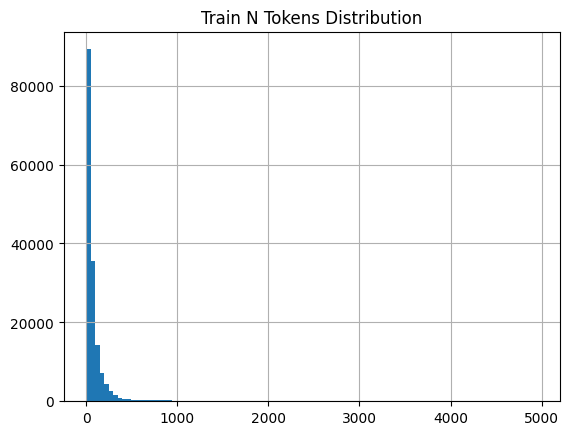

0.95 Quantile of N tokens: 267.0


In [136]:
train_n_tokens = train["comment_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [142]:
max_tokens = 300

train_torch_dataset = TextDataset(
    texts=train["light_clean_comment_text"].to_list(),
    targets=train[target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
    # trim_policy="first"
)

In [143]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: ". Fair use rationale for Image:Wonju.jpg. Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use. Please go to the image description page and edit it to include a fair use rationale. If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such an exp

In [144]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[2354,   20,    2,  ...,    0,    0,    0],
        [   8,   27,  191,  ..., 8092,    3,   40],
        [1216, 1504,  673,  ...,    0,    0,    0],
        ...,
        [  31,   58,  577,  ...,    0,    0,    0],
        [ 183,    1, 4534,  ...,    2,   32,   12],
        [   1, 5248,   33,  ...,    0,    0,    0]])
`Target` batch:
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


In [145]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="mps"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # TODO: Is mean a best choice ?
                # 2. Compute Backward path
                loss.mean().backward()
                # TODO: Try gradient clipping 
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

def print_losses(input):
    for cls_idx, cls_name in enumerate(target_columns):
        print(f"{tgt_col} BCE loss: {input[:,cls_idx].mean()}")
    print(f"Result BCE loss: {input.mean()}")

In [146]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=len(target_columns),
    average_type="mean"
).to("mps")

# TODO: Read more about different loss funcrions https://pytorch.org/docs/stable/nn.html#loss-functions
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
# TODO: Read more about Optimizers https://pytorch.org/docs/stable/optim.html
# TODO: Try to tune hyperparameters here
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
# TODO: Read more about schedulers https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [147]:
folds_ids = [el for el in stratifier.split(train, train["stratified_target"])]

train_torch_dataset = TextDataset(
    texts=train.iloc[folds_ids[0][0]]["comment_text"].to_list(),
    targets=train.iloc[folds_ids[0][0]][target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
)
# TODO: Read more about DataLoader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    # It is important to drop last batch while training. Why ?
    drop_last=True,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=train.iloc[folds_ids[0][1]]["comment_text"].to_list(),
    targets=train.iloc[folds_ids[0][1]][target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [148]:
TOKENIZERS_PARALLELISM=True

In [ ]:
# TODO: read this article about sample, batch, epoch differences - https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
# TODO: Try to train longer 
n_epochs = 3

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(n_epochs):
    print(f"Starting Epoch {epoch+1}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="mps",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    print("Train metrics")
    _, train_roc_auc = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="mps",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    print("Valid metrics")
    _, valid_roc_auc = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


  2%|▊                                     | 94/4487 [12:18<10:59:24,  9.01s/it]